In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
from tqdm import tqdm
from itertools import product
import matplotlib.colors as colors
#import matplotlib.cm as cm

import networkx as nx

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import geopandas as gpd
from shapely.geometry import Point
import pyproj
#pyproj.datadir.set_data_dir('/usr/local/share/proj')
from pyproj import CRS, Transformer
import folium

/home/biricza/.local/lib/python3.6/site-packages/pyproj/__init__.py:78: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


### Load data

In [2]:
source = '/mnt2/data/csv/'
#source = '/media/Data_storage/Mobilcell/Data/'

In [3]:
files_events = np.array( sorted([ i for i in os.listdir(source) if 'EVENTS' in i]) )
files_poligons = np.array( sorted([ i for i in os.listdir(source) if 'POLIGONS' in i]) )
files_events_cleaned = np.array( sorted([ i for i in os.listdir(source) if 'Events' in i]) )
files_events_cleaned.shape, files_events.shape, files_poligons.shape

((365,), (365,), (365,))

In [4]:
source+files_poligons[101], source+files_events[101]

('/mnt2/data/csv/MT_MTA_NETWORK_POLIGONS_20190312.csv.gz',
 '/mnt2/data/csv/MT_MTA_NETWORK_EVENTS_20190312.csv.gz')

In [5]:
poligons_df = pd.read_csv( source+files_poligons[101], delimiter=';' )
poligons_df.head()

,network_identifier,eovx,eovy,dx,dy,network_element_type
0,10071347,216918,496318,127,127,D
1,10071347,216918,496445,127,127,D
2,10071347,217045,496191,127,127,D
3,10071347,217045,496318,127,127,D
4,10071347,217045,496572,127,127,D


### Leave out those polygons that fall outside

In [6]:
poligons_df = poligons_df[ np.logical_and( poligons_df.eovx.values < 366660, poligons_df.eovx.values > 48210 ) ]
poligons_df = poligons_df[ np.logical_and( poligons_df.eovy.values < 934219, poligons_df.eovy.values > 426341 ) ]
poligons_df.shape

(26042095, 6)

In [7]:
np.unique(poligons_df.network_element_type.values)

array(['A', 'B', 'C', 'D', 'E', 'U'], dtype=object)

### Create coordinate system

In [8]:
poligons_df.eovx.values.min(), poligons_df.eovx.values.max()

(48262, 362968)

In [9]:
poligons_df.eovy.values.min(), poligons_df.eovy.values.max()

(426468, 934214)

#### Lets define a coordinate system of the small rasters

In [10]:
start_x = poligons_df.eovx.values.min()
start_y = poligons_df.eovy.values.min()
end_x = poligons_df.eovx.values.max()
end_y = poligons_df.eovy.values.max()
num_x = int( ( end_x - start_x ) / 127 )
num_y = int( ( end_y - start_y ) / 127 )
raster_x = np.arange(start_x, end_x+127, 127, dtype=np.int32)
raster_y = np.arange(start_y, end_y+127, 127, dtype=np.int32)
raster_x.shape, raster_y.shape # shapes should be one more than num!

((2479,), (3999,))

##### All coordinates

In [11]:
raster_coords = np.array( list(product( raster_x, raster_y )) )
raster_coords[:3], raster_coords.shape

(array([[ 48262, 426468],
        [ 48262, 426595],
        [ 48262, 426722]], dtype=int32),
 (9913521, 2))

##### Building blocks of the coordinates, structure revealed, no need to search for values in df

In [12]:
raster_coords[:,0].reshape( -1, (num_y+1) )[:3] # indexing: i * cols + j

array([[48262, 48262, 48262, ..., 48262, 48262, 48262],
       [48389, 48389, 48389, ..., 48389, 48389, 48389],
       [48516, 48516, 48516, ..., 48516, 48516, 48516]], dtype=int32)

#### Extend poligons dataframe 

In [13]:
poligons_df['eovx_num'] = ( (poligons_df.eovx - start_x) / 127 ).astype(int)
poligons_df['eovy_num'] = ( (poligons_df.eovy - start_y) / 127 ).astype(int)
poligons_df['eov_idx'] = poligons_df.eovx_num * (num_y+1) + poligons_df.eovy_num
poligons_df.head()

,network_identifier,eovx,eovy,dx,dy,network_element_type,eovx_num,eovy_num,eov_idx
0,10071347,216918,496318,127,127,D,1328,550,5311222
1,10071347,216918,496445,127,127,D,1328,551,5311223
2,10071347,217045,496191,127,127,D,1329,549,5315220
3,10071347,217045,496318,127,127,D,1329,550,5315221
4,10071347,217045,496572,127,127,D,1329,552,5315223


In [14]:
tower_id = np.unique( poligons_df.network_identifier.values )
tower_id[:5], tower_id.shape

(array([ 71892,  72307,  72922,  73325, 140903]), (43144,))

In [15]:
uniq, counts = np.unique(poligons_df.eov_idx, return_counts=True)

In [16]:
counts.min(), counts.max(), counts.sum(), poligons_df.shape[0]

(1, 107, 26042095, 26042095)

### Investigate events

In [17]:
events_df = pd.read_csv( source+files_events[101], delimiter=';' )
events_df.head()

,event_datetime,equipment_identifier,network_identifier,event_type,event_direction,country_code,device_tac
0,855,5C800000,12402278,V,O,216,86838903.0
1,855,5C800000,12402278,V,O,216,86838903.0
2,1017,5C800000,12402278,V,O,216,86838903.0
3,1024,5C800000,12402278,V,O,216,86838903.0
4,1024,5C800000,66644332,V,O,216,86838903.0


#### Add integer coded towers to dataframes

In [18]:
tower_to_int = dict(zip( tower_id, np.arange(tower_id.shape[0]) ))

In [19]:
poligons_df["tower_idx"] = [ tower_to_int[i] for i in poligons_df.network_identifier.values ]
poligons_df.head()

,network_identifier,eovx,eovy,dx,dy,network_element_type,eovx_num,eovy_num,eov_idx,tower_idx
0,10071347,216918,496318,127,127,D,1328,550,5311222,9069
1,10071347,216918,496445,127,127,D,1328,551,5311223,9069
2,10071347,217045,496191,127,127,D,1329,549,5315220,9069
3,10071347,217045,496318,127,127,D,1329,550,5315221,9069
4,10071347,217045,496572,127,127,D,1329,552,5315223,9069


In [20]:
events_df["tower_idx"] = [ tower_to_int[i] for i in events_df.network_identifier.values ]
events_df.head()

,event_datetime,equipment_identifier,network_identifier,event_type,event_direction,country_code,device_tac,tower_idx
0,855,5C800000,12402278,V,O,216,86838903.0,9368
1,855,5C800000,12402278,V,O,216,86838903.0,9368
2,1017,5C800000,12402278,V,O,216,86838903.0,9368
3,1024,5C800000,12402278,V,O,216,86838903.0,9368
4,1024,5C800000,66644332,V,O,216,86838903.0,13824


#### Sort polygons df in order to use a much quicker searching method (gain 1000x speed!)

In [21]:
poligons_df.sort_values( by='tower_idx', inplace=True )

In [22]:
poligons_df.tail()

,network_identifier,eovx,eovy,dx,dy,network_element_type,eovx_num,eovy_num,eov_idx,tower_idx
20582742,553841790,286514,824359,127,127,D,1876,3133,7505257,43143
20582743,553841790,286514,824486,127,127,D,1876,3134,7505258,43143
20582744,553841790,286514,824613,127,127,D,1876,3135,7505259,43143
20582746,553841790,286514,824867,127,127,D,1876,3137,7505261,43143
20582838,553841790,287276,824359,127,127,D,1882,3133,7529251,43143


### Investigation of equipment trajectories

#### Coding events with unique integer

In [23]:
event_id = np.unique( events_df.equipment_identifier.values )
event_id[:5], event_id.shape

(array(['5C800000', '5C800001', '5C800002', '5C800005', '5C800006'],
       dtype=object),
 (4278305,))

In [24]:
event_to_int = dict(zip( event_id, np.arange(event_id.shape[0]) ))

#### Adding this encoding to the dataframe

In [25]:
events_df["event_idx"] = [ event_to_int[i] for i in events_df.equipment_identifier.values ]
events_df.head()

,event_datetime,equipment_identifier,network_identifier,event_type,event_direction,country_code,device_tac,tower_idx,event_idx
0,855,5C800000,12402278,V,O,216,86838903.0,9368,0
1,855,5C800000,12402278,V,O,216,86838903.0,9368,0
2,1017,5C800000,12402278,V,O,216,86838903.0,9368,0
3,1024,5C800000,12402278,V,O,216,86838903.0,9368,0
4,1024,5C800000,66644332,V,O,216,86838903.0,13824,0


In [26]:
eq_diff_idx = np.where( np.diff(events_df.event_idx.values) )[0]+1
eq_diff_idx.shape

(4278304,)

In [27]:
eq_trajectories_towers = []
eq_trajectories_time = []
for i in tqdm( range( eq_diff_idx.shape[0]-1 ) ):
    start_ = eq_diff_idx[i]
    end_ = eq_diff_idx[i+1]
    eq_trajectories_towers.append( events_df.tower_idx.values[ start_:end_ ] )
    eq_trajectories_time.append( events_df.event_datetime.values[ start_:end_ ] )

100%|██████████| 4278303/4278303 [00:56<00:00, 75673.93it/s]


In [28]:
eq_trajectories_towers = np.array( eq_trajectories_towers ) # array of variable length arrays
eq_trajectories_time = np.array( eq_trajectories_time ) # array of variable length arrays
eq_trajectories_towers.shape, eq_trajectories_time.shape

/home/biricza/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/home/biricza/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


((4278303,), (4278303,))

##### Get number of unique towers in trajectories, 1 means an eq that is still

In [29]:
eq_trajectories_towers_uq = np.array([ np.shape(np.unique(i))[0] for i in eq_trajectories_towers ])
eq_trajectories_towers_uq.shape, eq_trajectories_towers_uq[:3]

((4278303,), array([3, 3, 1]))

#### Filter out resting events, then test if everything is correct

In [30]:
eq_trajectories_time = eq_trajectories_time[ eq_trajectories_towers_uq > 1 ]
eq_trajectories_towers = eq_trajectories_towers[ eq_trajectories_towers_uq > 1 ]

In [31]:
eq_trajectories_time.shape, eq_trajectories_towers.shape

((3417099,), (3417099,))

In [32]:
eq_trajectories_time[0], eq_trajectories_towers[0]

(array([  16,  641,  648,  648,  732,  739,  739,  801,  829,  836,  837,
         837,  854,  946, 1325, 1326, 1352, 1352, 1514, 1517, 1844]),
 array([20537, 20537, 20537, 20537, 20537, 20537, 20537, 14861, 14861,
        14861, 14861, 14861, 14960, 14960, 14861, 14861, 14861, 14861,
        14861, 14861, 20537]))

In [ ]:
events_df[ events_df.event_idx == 1 ]

### Investigate the area of polygons

In [33]:
tower_diff_idx = np.where( np.diff(poligons_df.tower_idx.values) )[0]+1
# insert first element (zero)
tower_diff_idx = np.insert(tower_diff_idx, 0, 0, axis=0)
# insert last element (size of array)
tower_diff_idx = np.append( tower_diff_idx, poligons_df.tower_idx.values.shape[0] )
tower_diff_idx.shape, tower_diff_idx[-3:]

((43145,), array([26041229, 26041701, 26042095]))

In [34]:
tower_rasters = []
for i in tqdm( range( tower_diff_idx.shape[0]-1 ) ):
    start_ = tower_diff_idx[i]
    end_ = tower_diff_idx[i+1]
    tower_rasters.append( poligons_df.eov_idx.values[ start_:end_ ] )
tower_rasters = np.array(tower_rasters)

100%|██████████| 43144/43144 [00:00<00:00, 138479.50it/s]
/home/biricza/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [35]:
tower_coords_all = []
tower_std_all = []
for i in tqdm( range( tower_rasters.shape[0] ) ):
    tower_coords_all.append( np.mean( raster_coords[ tower_rasters[i] ], 0 ) )
    tower_std_all.append( np.std( raster_coords[ tower_rasters[i] ], 0 ) )  
tower_coords_all = np.array( tower_coords_all )
tower_std_all = np.array( tower_std_all )

100%|██████████| 43144/43144 [00:05<00:00, 8233.44it/s] 


### Checking variables

Events encodings:
- eq_trajectories_time
- eq_trajectories_towers

Polygons encodings:
- tower_coords_all

#### Load datetime vector and convert time to minutes

In [40]:
dates_clock = np.loadtxt( "../Data/event_datetime.csv").astype(int) # time on clock
dates_time = np.arange( 1440 ) # time in sec
time_to_sec = dict( zip(dates_clock, dates_time) )
dates_clock.shape, dates_time.shape

((1440,), (1440,))

#### Processing day graph

In [41]:
eq_trajectories_towers_uq

array([3, 3, 1, ..., 2, 2, 4])

In [42]:
tower_rasters.shape, tower_coords_all.shape, 

((43144,), (43144, 2))

In [44]:
curr = 5949
eps = 1e-7 # add small time to avoid division by zero
# get indices
eq_path = np.vstack( (eq_trajectories_towers[curr][:-1], eq_trajectories_towers[curr][1:]) ).T
# filter if source and destination is the same
filt = (eq_path[:,0] != eq_path[:,1])
eq_path = eq_path[filt]
eq_time_ = np.array( list( map(time_to_sec.get, eq_trajectories_time[curr]) ) )
eq_time_min = eq_time_[1:] - eq_time_[:-1]
eq_time_min = eq_time_min[filt] / 60
eq_dist_km = np.sqrt( np.sum( (tower_coords_all[ eq_path[:,1] ] - \
                  tower_coords_all[ eq_path[:,0] ])**2, 1 ) ) / 1000
eq_speed_kmh = (eq_dist_km/(eq_time_min+eps)).astype(int)
filt = np.logical_and( eq_speed_kmh > 0, eq_speed_kmh < 180 )
np.concatenate( (eq_path[filt], np.ones(filt.sum()).reshape(-1,1) ), axis=1).astype(int)

array([[14814, 15443,     1],
       [10462, 30884,     1],
       [30884, 18982,     1],
       [18982, 10395,     1],
       [38842, 31398,     1],
       [30444, 27197,     1],
       [24853, 27197,     1],
       [27197, 14904,     1],
       [ 8694, 27197,     1],
       [27197,  9279,     1],
       [ 9279,  9278,     1],
       [ 9278, 27197,     1],
       [27197, 32737,     1],
       [38217,  9754,     1],
       [ 9754, 14814,     1],
       [14814, 30981,     1],
       [30981, 14814,     1],
       [14814, 30981,     1],
       [30981, 14814,     1]])

In [45]:
# this can be paralellizable!
graph_edge_list_raw = []
eps = 1e-6 # add small time to avoid division by zero
for curr in tqdm( range( eq_trajectories_towers.shape[0] ) ):
    # get indices
    eq_path = np.vstack( (eq_trajectories_towers[curr][:-1], eq_trajectories_towers[curr][1:]) ).T
    # filter if source and destination is the same
    filt = (eq_path[:,0] != eq_path[:,1])
    eq_path = eq_path[filt]
    eq_time_ = np.array( list( map(time_to_sec.get, eq_trajectories_time[curr]) ) )
    eq_time_min = eq_time_[1:] - eq_time_[:-1]
    eq_time_min = eq_time_min[filt] / 60
    eq_dist_km = np.sqrt( np.sum( (tower_coords_all[ eq_path[:,1] ] - \
                      tower_coords_all[ eq_path[:,0] ])**2, 1 ) ) / 1000
    eq_speed_kmh = (eq_dist_km/eq_time_min+eps).astype(int)
    filt = np.logical_and( eq_speed_kmh > 0, eq_speed_kmh < 180 )
    graph_edge_list_raw.append( np.concatenate( (eq_path[filt], 
                                                 np.ones(filt.sum()).reshape(-1,1) ), 
                                               axis=1).astype(int) )

  0%|          | 0/3417099 [00:00<?, ?it/s]/home/biricza/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/biricza/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
100%|██████████| 3417099/3417099 [05:36<00:00, 10154.38it/s]


In [46]:
graph_edge_list_raw = np.concatenate( graph_edge_list_raw )
graph_edge_list_raw.shape

(27128630, 3)

In [47]:
uq_, counts_ = np.unique(graph_edge_list_raw, axis=0, return_counts=True)
uq_.shape, counts_.shape

((5131468, 3), (5131468,))

In [48]:
graph_edge_list = np.concatenate( (uq_[:,:2], counts_.reshape(-1, 1)), axis=1 )
graph_edge_list.shape, graph_edge_list[:5]

((5131468, 3),
 array([[   0,    1,   52],
        [   0,    2,   51],
        [   0,    3,   20],
        [   0,  784,    1],
        [   0, 1399,    1]]))

In [50]:
graph_edge_list[:,2].min(), graph_edge_list[:,2].max()

(1, 4051)

### Saving graph file to csv

In [46]:
pd.DataFrame( np.concatenate( ( graph_edge_list, tower_coords_all[ graph_edge_list[:,0] ], 
                                tower_coords_all[ graph_edge_list[:,1] ] ), 
                             axis=1  ), columns=[ ["src", "dst", "weight", 
                                                 "src_eovx", "src_eovy", 
                                                 "dst_eovx", "dst_eovy"] ] ).to_csv("Testdaygraph", index=False)

### End of this notebook, just testing for now

In [51]:
src_part = graph_edge_list[:,0]
dst_part = graph_edge_list[:,1]
weight_part = []

for i in range( graph_edge_list[:,0].shape[0] ):
    weight_part.append( '{\'weight\': '+str( np.round( graph_edge_list[:,2][i], 4 ) )[:7]+'}' )
weight_part = np.array( weight_part )

In [52]:
grap_to_parse = []
for i in range( src_part.shape[0] ):
     grap_to_parse.append( str(src_part[i]) + ' ' + str( dst_part[i]) +' ' + weight_part[i] )

In [53]:
import networkx as nx

In [54]:
G = nx.parse_edgelist( grap_to_parse , delimiter=' ', nodetype=int, create_using=nx.Graph())

In [55]:
len(G.nodes()), len(G.edges())

(36366, 3933209)

In [57]:
G_directed = nx.parse_edgelist( grap_to_parse , delimiter=' ', nodetype=int, create_using=nx.DiGraph())

In [59]:
len(G_directed.nodes()), len(G_directed.edges())

(36366, 5131468)

In [71]:
G.get_edge_data( 0, 1 ), G.get_edge_data( 1, 0 )

({'weight': 54}, {'weight': 54})

In [72]:
G_directed.get_edge_data( 0, 1 ), G_directed.get_edge_data( 1, 0 )

({'weight': 52}, {'weight': 54})

In [74]:
crs_eov = CRS.from_epsg("23700")
crs_lonlat = CRS.from_epsg("4326")
#crs_eov, crs_lonlat
transformer = Transformer.from_crs(crs_eov, crs_lonlat)

CRSError: Invalid projection: epsg:23700: (Internal Proj Error: proj_create: no database context specified)

In [331]:
x_, y_ = transformer.transform( xx=tower_coords_all[ np.array(list(G.nodes)) ][:,1],
                                yy=tower_coords_all[ np.array(list(G.nodes)) ][:,0]  )
x_.shape, y_.shape

((36357,), (36357,))

#### Plotting the nodes only

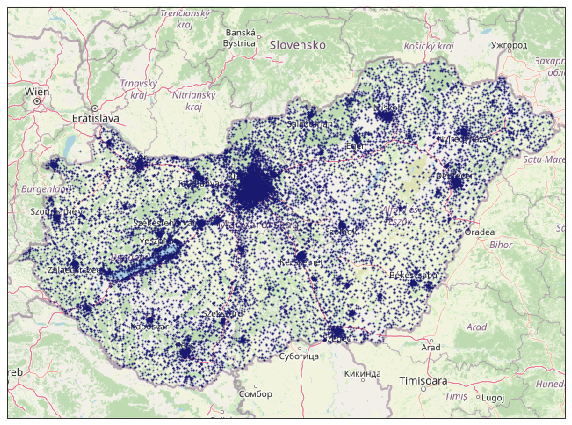

In [352]:
# https://stackoverflow.com/questions/50611018/cartopy-heatmap-over-openstreetmap-background
request = cimgt.OSM() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(10,18), subplot_kw=dict(projection=request.crs))
extent = [16, 23, 45.5, 49]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 7) # 8 is a layer num, higher means more detail

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
xynps = ax.projection.transform_points( ccrs.Geodetic(), x=y_, y=x_)
plt.scatter( xynps[:,0], xynps[:,1], s=1, alpha=0.5, marker='o', color='midnightblue' )

#### Plotting graph on map

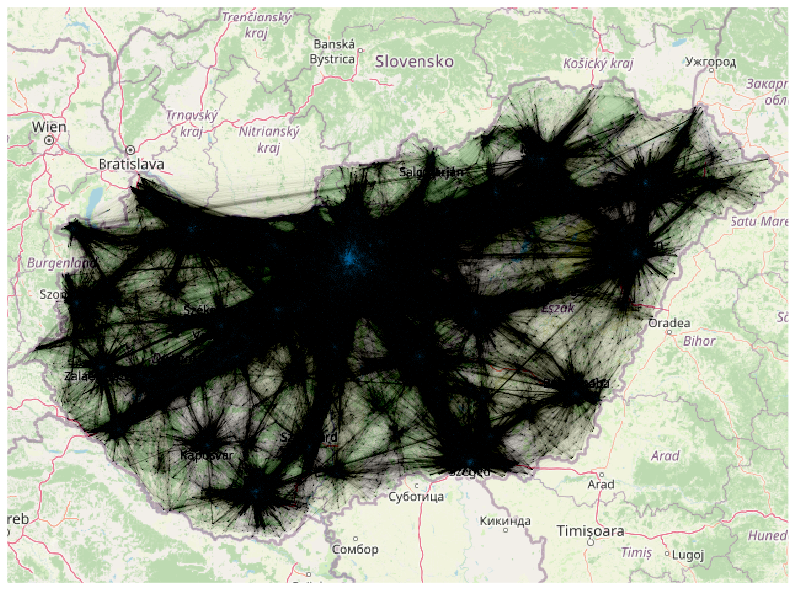

In [358]:
# Plot graph on map
request = cimgt.OSM() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(14,20), subplot_kw=dict(projection=request.crs))
extent = [16, 23, 45.5, 49]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 7) # 7 is a layer num, higher means more detail

graph_lon = y_#x_ #boxids.iloc[list(g.nodes)].values[:,-1]
graph_lat = x_#y_ #boxids.iloc[list(g.nodes)].values[:,-2]

pos_lonlat_nx = { j : ( graph_lon[i], 
                     graph_lat[i] ) for i, j in enumerate(list(G.nodes)) }

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
pos_geo = ax.projection.transform_points( ccrs.Geodetic(), 
                                        graph_lon, graph_lat)

pos_geo_nx = { j : ( pos_geo[i,0], 
                     pos_geo[i,1] ) for i, j in enumerate(list(G.nodes)) }
nx.draw(G, pos=pos_geo_nx, node_size=0.1, alpha=0.05, width=0.1)

### Todo
- Filter high speed events - done
- Box grid graph creation - is this really necessary?!
- day graph generation - done

### Automatization of the above process

#### This script can be used from command line:

In [1]:
# this script is create by A. Biricz, 29.11.2020.
# Arguments:
# --source_folder
# --target_folder

# Add command line arguments

import numpy as np
import pandas as pd
from itertools import product
import os
from tqdm import tqdm

# Locate files
source = '/media/Data_storage/Mobilcell/Data/'
target = '/media/Data_storage/Mobilcell/DayGraphData/'

files_events = np.array( sorted([ i for i in os.listdir(source) if 'EVENTS' in i]) )
files_poligons = np.array( sorted([ i for i in os.listdir(source) if 'POLIGONS' in i]) )
files_events_cleaned = np.array( sorted([ i for i in os.listdir(source) if 'Events' in i]) )

def calculate_day_graph( source, target, poligons_path, events_path ):
    
    # load data
    print("loading input data")
    poligons_df = pd.read_csv( source+poligons_path, delimiter=';' )
    events_df = pd.read_csv( source+events_path, delimiter=';' )

    # drop poligons outside of the country
    poligons_df = poligons_df[ np.logical_and( poligons_df.eovx.values < 366660, 
                                               poligons_df.eovx.values > 48210 ) ]
    poligons_df = poligons_df[ np.logical_and( poligons_df.eovy.values < 934219, 
                                               poligons_df.eovy.values > 426341 ) ]

    # create coordinate system for the rasters (much easier and faster to generate than search and match)
    start_x = poligons_df.eovx.values.min()
    start_y = poligons_df.eovy.values.min()
    end_x = poligons_df.eovx.values.max()
    end_y = poligons_df.eovy.values.max()
    num_x = int( ( end_x - start_x ) / 127 )
    num_y = int( ( end_y - start_y ) / 127 )
    raster_x = np.arange(start_x, end_x+127, 127, dtype=np.int32)
    raster_y = np.arange(start_y, end_y+127, 127, dtype=np.int32)
    
    # get coordinate vector
    raster_coords = np.array( list(product( raster_x, raster_y )) )
    raster_coords[:3], raster_coords.shape

    # calculate raster encodings
    poligons_df['eovx_num'] = ( (poligons_df.eovx - start_x) / 127 ).astype(int)
    poligons_df['eovy_num'] = ( (poligons_df.eovy - start_y) / 127 ).astype(int)
    poligons_df['eov_idx'] = poligons_df.eovx_num * (num_y+1) + poligons_df.eovy_num
    
    # calculate tower encodings
    tower_id = np.unique( poligons_df.network_identifier.values )
    uniq, counts = np.unique(poligons_df.eov_idx, return_counts=True)
    tower_to_int = dict(zip( tower_id, np.arange(tower_id.shape[0]) ))

    # add encodings to the dataframes
    poligons_df["tower_idx"] = [ tower_to_int[i] for i in poligons_df.network_identifier.values ]
    events_df["tower_idx"] = [ tower_to_int[i] for i in events_df.network_identifier.values ]
    
    # sort the smaller dataframe for much quicker searching
    poligons_df.sort_values( by='tower_idx', inplace=True )
    
    # calculate event (equipment id) encodings
    event_id = np.unique( events_df.equipment_identifier.values )
    event_to_int = dict(zip( event_id, np.arange(event_id.shape[0]) ))
    
    # add event encodings to the dataframes
    events_df["event_idx"] = [ event_to_int[i] for i in events_df.equipment_identifier.values ]

    # partitioning the event dataframe to track individual events
    eq_diff_idx = np.where( np.diff(events_df.event_idx.values) )[0]+1
    
    # calculate trajectories of events (to which tower it connects to and when)
    eq_trajectories_towers = []
    eq_trajectories_time = []
    print("calculate trajectories of events..")
    for i in tqdm( range( eq_diff_idx.shape[0]-1 ) ):
        start_ = eq_diff_idx[i]
        end_ = eq_diff_idx[i+1]
        eq_trajectories_towers.append( events_df.tower_idx.values[ start_:end_ ] )
        eq_trajectories_time.append( events_df.event_datetime.values[ start_:end_ ] )
    
    # these arrays holds the information about the events
    eq_trajectories_towers = np.array( eq_trajectories_towers ) # array of variable length arrays!
    eq_trajectories_time = np.array( eq_trajectories_time ) # array of variable length arrays!
    
    # check for unique values and drop events that stand still for the whole day
    eq_trajectories_towers_uq = np.array([ np.shape(np.unique(i))[0] for i in eq_trajectories_towers ])
    eq_trajectories_time = eq_trajectories_time[ eq_trajectories_towers_uq > 1 ]
    eq_trajectories_towers = eq_trajectories_towers[ eq_trajectories_towers_uq > 1 ]

    # partitioning the poligon dataframe to locate individual towers
    tower_diff_idx = np.where( np.diff(poligons_df.tower_idx.values) )[0]+1
    # insert first element (zero) ## otherwise left out!
    tower_diff_idx = np.insert(tower_diff_idx, 0, 0, axis=0)
    # insert last element (size of array) ## otherwise left out!
    tower_diff_idx = np.append( tower_diff_idx, poligons_df.tower_idx.values.shape[0] )

    # collect all rasters for the towers
    tower_rasters = []
    print("collect all rasters for the towers..")
    for i in tqdm( range( tower_diff_idx.shape[0]-1 ) ):
        start_ = tower_diff_idx[i]
        end_ = tower_diff_idx[i+1]
        tower_rasters.append( poligons_df.eov_idx.values[ start_:end_ ] )
    tower_rasters = np.array(tower_rasters)

    # calculate coordinates of the towers (and its error with std for now)
    tower_coords_all = []
    tower_std_all = []
    print("calculate coordinates of the towers..")
    for i in tqdm( range( tower_rasters.shape[0] ) ):
        tower_coords_all.append( np.mean( raster_coords[ tower_rasters[i] ], 0 ) )
        tower_std_all.append( np.std( raster_coords[ tower_rasters[i] ], 0 ) )  
    tower_coords_all = np.array( tower_coords_all )
    tower_std_all = np.array( tower_std_all )
    
    # load datetime variable to code time as minutes
    dates_clock = np.loadtxt( "event_datetime.csv").astype(int) # time on clock
    dates_time = np.arange( 1440 ) # time in sec
    time_to_sec = dict( zip(dates_clock, dates_time) )

    # building the day graph, defining it with its edge list.. (it is paralellizable!)
    graph_edge_list_raw = []
    eps = 1e-6 # add small time to avoid division by zero
    print("building the graph, defining it with its edge list..")
    for curr in tqdm( range( eq_trajectories_towers.shape[0] ) ):
        # get indices
        eq_path = np.vstack( (eq_trajectories_towers[curr][:-1], eq_trajectories_towers[curr][1:]) ).T
        # filter if source and destination is the same
        filt = (eq_path[:,0] != eq_path[:,1])
        eq_path = eq_path[filt]
        eq_time_ = np.array( list( map(time_to_sec.get, eq_trajectories_time[curr]) ) )
        eq_time_min = eq_time_[1:] - eq_time_[:-1]
        eq_time_min = eq_time_min[filt] / 60
        eq_dist_km = np.sqrt( np.sum( (tower_coords_all[ eq_path[:,1] ] - \
                          tower_coords_all[ eq_path[:,0] ])**2, 1 ) ) / 1000
        eq_speed_kmh = (eq_dist_km/eq_time_min+eps).astype(int)
        filt = np.logical_and( eq_speed_kmh > 0, eq_speed_kmh < 180 )
        graph_edge_list_raw.append( np.concatenate( (eq_path[filt], 
                                                     np.ones(filt.sum()).reshape(-1,1) ), 
                                                   axis=1).astype(int) )
    
    # finalizing the edge list by removing duplicate lines and collecting edge weights
    print("finalizing the output..")
    graph_edge_list_raw = np.concatenate( graph_edge_list_raw )
    uq_, counts_ = np.unique(graph_edge_list_raw, axis=0, return_counts=True)
    graph_edge_list = np.concatenate( (uq_[:,:2], counts_.reshape(-1, 1)), axis=1 )
    
    print("saving results to disk..")
    # saving resulting dataframe to disc with coordinates of the source and destination towers
    savename = target + 'output_day-graph-by-edgelist_' + events_path.split('.csv')[0][-8:]+'.csv.gz'
    pd.DataFrame( np.concatenate( ( graph_edge_list, 
                                    tower_coords_all[ graph_edge_list[:,0] ], 
                                    tower_coords_all[ graph_edge_list[:,1] ] ), 
                                  axis=1  ), 
                  columns=[ ["src", "dst", "weight", 
                             "src_eovx", "src_eovy", 
                             "dst_eovx", "dst_eovy"] ] ).to_csv( savename, 
                                                                 index=False, 
                                                                 compression='gzip')

# call this function like this:
# calculate_day_graph( source, target, files_poligons[100], files_events[100] )
for q in range(1,183)
    calculate_day_graph( source, target, files_poligons[q], files_events[q] )

  0%|          | 0/3113204 [00:00<?, ?it/s]/home/abiricz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:140: RuntimeWarning: divide by zero encountered in true_divide
/home/abiricz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 3113204/3113204 [04:16<00:00, 12125.92it/s]
